# Convolutional Neural Network

**Conv Layer**

  - Accepts a volume of size $W_1 \times H_1 \times D_q$
  - Requires four hyperparameters:
    - Number of filters $K$,
    - their spatial extent $F$,
    - the stride $S$,
    - the amount of zero padding $P$
  - Produce a volume of size $W_2 \times H_2 \times D_2$
    - $W_2 = (W_1 - F + 2 P) / S + 1$
    - $H_2 = (H_1 - F + 2 P) / S + 1$ (i.e width and height are computed equally by symmetry)
    - $D_2 = K$
  - With parameter sharing, it introduces $F \cdot F \cdot D_1$ weights per filter, for a total of $(F \cdot F \cdot D_1) \cdot K$ weights and $K$ biases.
  - In the output of volume, the $d$-th depth slice (of size $W_2 \times H_2$) is the result of performing a valid convolution of the $d$-th filter over the input volume with a stride of $S$, and then offset by $d$-th bias.

See lecture [CS231n Winter 2016: Lecture 7: Convolutional Neural Networks](https://youtu.be/LxfUGhug-iQ)

**Common Settings**

K = (powers of 2, e.g. 32, 64, 128, 512)
  - F = 3, S = 1, P = 1
  - F = 5, S = 1, P = 2,
  - F = 5, S = 2, P = ? (whatever fits)
  - F = 1, S = 1, P = 0

## SpatialConvolution

Example: CONV layer in Torch

```python
module = nn.SpatialConvolution(nInputPlane, nOutputPlane, kW, kH, [dW], [dH], [padW], [padH])
```

## ReLU Layer

## Pooling Layer

## Fully Connected Layer (FC)

# Prepare data

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dropout = 0.25
seed = 1337

In [3]:
# Download and load the MNIST dataset for numbers
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download dataset for training and test
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert to loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2);

# Sample data

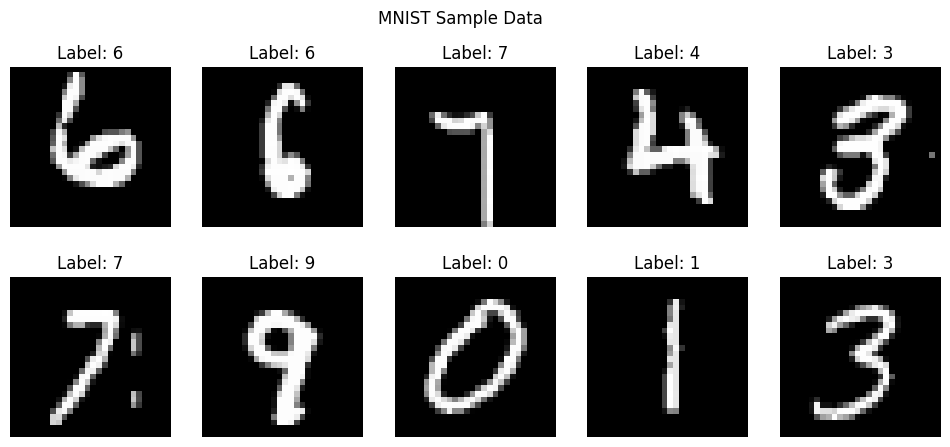

In [4]:
fig, axis = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('MNIST Sample Data')

torch.manual_seed(seed)
indices = torch.randint(len(train_set), size=(10,))
for i, index in enumerate(indices):
    image, label = train_set[index]
    
    image = image.squeeze().numpy()
    axis[i // 5, i % 5].imshow(image, cmap='gray')
    axis[i // 5, i % 5].set_title(f'Label: {label}')
    axis[i // 5, i % 5].axis('off')

In [5]:
train_set[0][0].shape

torch.Size([1, 28, 28])

# CNN Model

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Regulation technique used to prevent overfitting.
        # Basic idea set some neuron activity to zero.
        self.dropout = nn.Dropout(0.25)  # 25 percent change of dropout
        # Fully connected
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 output size of conv2, 7 is from the number after two max pooling.
        self.fc2 = nn.Linear(128, 10)          # Output layer

    def forward(self, x):
        """ 2 Convolutional Layer and 2 Fully connected layer """
        x = F.relu(self.conv1(x))  # convolution then relu
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)    # convert tensor to 1 dimensional shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training

In [7]:
# Instance of the Model
model = CNNModel().to(device)

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST dataset
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print training progress
    print('Epoch [{}/{}], Loss: {:.3E}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 2.790E-03
Epoch [2/10], Loss: 6.625E-02
Epoch [3/10], Loss: 1.084E-02
Epoch [4/10], Loss: 3.315E-03
Epoch [5/10], Loss: 7.103E-03
Epoch [6/10], Loss: 1.468E-02
Epoch [7/10], Loss: 1.198E-04
Epoch [8/10], Loss: 1.293E-03
Epoch [9/10], Loss: 3.207E-05
Epoch [10/10], Loss: 1.046E-02


In [9]:
torch.save(model.state_dict(), 'model.pth')

Save trained model

```python
torch.save(model.state_dict(), 'model.pth')
```

Load model

```python
model = CNNModel()
model.load_state_dict(torch.load('model.pth'))
```

# Testing

In [10]:
model = CNNModel()
model.load_state_dict(torch.load('model.pth'))

def model_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

model = model.to(device)
model.eval()
# Calculate accuracyt on the test set
test_accuracy = model_accuracy(model, test_loader)
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 99.28%


# Convert to ONNX

In [11]:
import torch.onnx

model = CNNModel()
model.load_state_dict(torch.load('model.pth'))

model.eval()
dummy_input = torch.randn(1, 1, 28, 28, requires_grad=True)

torch.onnx.export(model,
                  dummy_input,
                  'model.onnx',
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={
                      'input': { 0 : 'batch_size' },
                      'output': { 0 : 'batch_size' }
                  }
                 )

# Load ONNX

In [12]:
# import torch.onnx

# onnx_model = torch.onnx.load('model.onnx')
# pytorch_model = torch.nn.Sequenctial()
# for onnx_layer in onnx_model.graph.node:
#     pytorch_layer = conver